In [1]:
import pathlib 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import KFold
from tensorflow.keras.utils import plot_model

# import eli5
# from eli5.sklearn import PermutationImportance
tf.compat.v1.disable_eager_execution()
# tf.debugging.set_log_device_placement(True)



def norm(x):     
    return (x-min)/(max-min)

def r2(inp,pred):
    Minp= np.mean(inp)
    Mpred=np.mean(pred)
    
    temp1=inp-Minp
    temp2=pred-Mpred

    temp3= temp1**2
    temp4=temp2**2

    temp5=np.sqrt(np.sum(temp3))
    temp6=np.sqrt(np.sum(temp4))

    temp7= np.sum(temp1*temp2)
    temp8=temp5*temp6
    cor=temp7/temp8
    return cor**2 

def mae(inp,pred):
    temp1= np.abs(inp-pred)
    temp1=np.mean(temp1)

    return temp1

def rmse(inp,pred):
    temp1= (inp-pred)**2
    temp1=np.mean(temp1)
    temp1=np.sqrt(temp1)
    return temp1

        

# get dataset from csv file 
folder_path='Training\\'
if os.path.exists(folder_path)==False:
    os.mkdir(folder_path)
data_path='training.csv'
test_path='test.csv'

max=[1000,20,35,2000,40000,150,100,2500]
max=np.array(max)
min=[0,0,0,0,0,0,0,0]
min=np.array(min)
#normalization


column_names=['Yield Strengh','UTS','Cr %','Depth','Strikes/mm2','Static Force','Amplitude','Residual Stress']
column_names_r=['Yield Strengh','UTS','Cr %','Depth','Strikes/mm2','Static Force','Amplitude']
raw_dataset =pd.read_csv(data_path,names=column_names, skipinitialspace=True)
raw_dataset2=pd.read_csv(test_path,names=column_names, skipinitialspace=True)
train_dataset=norm(raw_dataset.copy())
test_dataset=norm(raw_dataset2.copy())
x_column=train_dataset.columns.drop('Residual Stress')
x=train_dataset[x_column].values
y=train_dataset['Residual Stress'].values

x_val=test_dataset[x_column].values
y_val=test_dataset['Residual Stress'].values

# This part is for the training process:

In [2]:
def build_model(n1,n2):
    inputL = Input(shape=(7,))

        
    z=Dense(n1,activation="relu")(inputL)
    z=Dense(n2,activation="relu")(z)
    z=Dense(1,activation="tanh")(z)
        
    x=Model(inputs=inputL, outputs=z)
       
    return x


In [11]:
def go_train(n1,n2):
    
    num=1
    dir_path=dir_path=folder_path+'Trial-'+str(num)+'\\'
    while os.path.exists(dir_path):
        num=num+1
        dir_path=dir_path=folder_path+'Trial-'+str(num)+'\\'

    os.mkdir(dir_path)
    
    
    #NN parameter
    EPOCHS=40000
    LR=0.0025
    #loss_function= 'mean_absolute_error' 
    loss_function= 'mean_squared_error'
    optimizer = tf.keras.optimizers.Adam(LR)
    #optimizer = tf.keras.optimizers.RMSprop(0.01)
    kf=KFold(4,shuffle=True, random_state=0)

    fold=0
    r2_train=[]
    r2_test=[]
    rmse_train=[]
    rmse_test=[]
    mae_train=[]
    mae_test=[]
    e=[]

    early_stop=keras.callbacks.EarlyStopping(monitor='val_loss',mode='min',patience=50)

    for train, test in kf.split(x):
        fold+=1

        x_train=x[train]
        y_train=y[train]
        x_test=x[test]
        y_test=y[test]


        model=build_model(n1,n2)

        # compile model
        model.compile(loss=loss_function,optimizer=optimizer, metrics=['mean_absolute_error','mean_squared_error'])

        history= model.fit(x_train,y_train , epochs=EPOCHS, validation_data=(x_test,y_test), verbose = 0,callbacks=[early_stop])

        hist = pd.DataFrame(history.history)
        hist['epoch'] = history.epoch
        hist.to_csv(dir_path+'hist'+str(fold)+'.csv')
        
        
#         fig, (ax1,ax2)= plt.subplots(figsize=(12,4),nrows=1,ncols=2)
#         ax1.set_xlabel('Epoch')
#         ax1.set_ylabel('Mean Abs Error')
#         ax1.plot(hist['epoch'], hist['mean_absolute_error'],
#                                label='Train Error')
#         ax1.plot(hist['epoch'], hist['val_mean_absolute_error'],
#                                label='Val Error')
#         ax1.set_ylim([0,hist['mean_absolute_error'].iloc[0]])
#         ax1.legend()
      
        
#         ax2.set_xlabel('Epoch')
#         ax2.set_ylabel('Mean Square Error')
#         ax2.plot(hist['epoch'], hist['mean_squared_error'],
#                                label='Train Error')
#         ax2.plot(hist['epoch'], hist['val_mean_squared_error'],
#                                label='Val Error')
#         ax2.set_ylim([0,hist['mean_squared_error'].iloc[0]])
#         ax2.legend()
        
#         plt.tight_layout()
#         plt.show()
        
        train_predictions= model.predict(x_train).flatten()
        test_predictions= model.predict(x_test).flatten()

        name=dir_path+'pred_test'+str(fold)+'.csv'
        test_res=pd.DataFrame(x_test,columns=column_names_r)
        test_res['Residual Stress']=y_test
        test_res['Predict']=test_predictions
        test_res.to_csv(name)
                
        name=dir_path+'pred_train'+str(fold)+'.csv'
        train_res=pd.DataFrame(x_train,columns=column_names_r)
        train_res['Residual Stress']=y_train
        train_res['Predict']=train_predictions
        train_res.to_csv(name)
                


        r2_train.append(r2(y_train,train_predictions))
        r2_test.append(r2(y_test,test_predictions))
        rmse_train.append(rmse(y_train,train_predictions))
        rmse_test.append(rmse(y_test,test_predictions))
        mae_train.append(mae(y_train,train_predictions))
        mae_test.append(mae(y_test,test_predictions))
        e.append(hist['epoch'].tail(1).iloc[0])

    r2_train_f=np.mean(r2_train)
    r2_train_std=np.std(r2_train)
    r2_test_f=np.mean(r2_test)
    r2_test_std=np.std(r2_test)
    rmse_train_f=np.mean(rmse_train)
    rmse_train_std=np.std(rmse_train)
    rmse_test_f=np.mean(rmse_test)
    rmse_test_std=np.std(rmse_test)
    mae_train_f=np.mean(mae_train)
    mae_train_std=np.std(mae_train)
    mae_test_f=np.mean(mae_test)
    mae_test_std=np.std(mae_test)  
    e_mean=np.max(e)
    o_af=0 # 0=linear , 1=tanh
    train_log_name='train_log.csv'
    columns=['Train_R2','Train_R2 std','Train_RSME','Train_RSME std','Train_MAE','Train_MAE std','Test_R2','Test_R2 std','Test_RSME','Test_RSME std','Test_MAE','Test_MAE std','Epoch','LR','Output AF']
#     columns_=['Network','Train_R2','std','Train_RSME','std','Train_MAE','std','Test_R2','std','Test_RSME','std','Test_MAE','std']
    
    
    temp=np.array([r2_train_f,r2_train_std,rmse_train_f,
                  rmse_train_std,mae_train_f,mae_train_std,r2_test_f,
                  r2_test_std,rmse_test_f,rmse_test_std,mae_test_f,mae_test_std,e_mean,LR,o_af])
                  
    temp=temp.reshape(1,15)              
    
    dummy_1=pd.DataFrame(['Trial-'+str(num)+'(7 x '+str(n1)+' x '+str(n2)+' x 1)'],columns=['Network'])              
    dummy_2=pd.DataFrame(temp,columns=columns)
    dummy=pd.concat([dummy_1,dummy_2],axis=1)
    
    
    if os.path.exists(train_log_name)==False:
        train_log=dummy.copy()
        train_log.to_csv(train_log_name,index=False)
     
    
    else:
        train_log =pd.read_csv(train_log_name,skipinitialspace=True)
        train_log =pd.concat([train_log,dummy],axis=0,sort=False)
        train_log.to_csv(train_log_name,index=False)
        
    K.clear_session()
    print('Trial-',num,'is Finished')

In [12]:
for n1 in range(10,31,2):
    go_train(n1,n1)


Trial- 45 is Finished
Trial- 46 is Finished
Trial- 47 is Finished
Trial- 48 is Finished
Trial- 49 is Finished
Trial- 50 is Finished
Trial- 51 is Finished
Trial- 52 is Finished
Trial- 53 is Finished
Trial- 54 is Finished
Trial- 55 is Finished


# For building final model 

Trial- 8
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


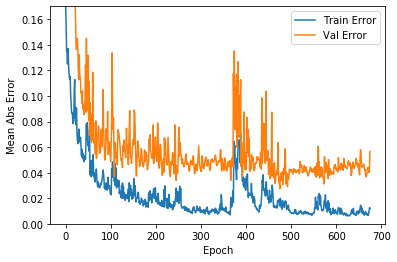

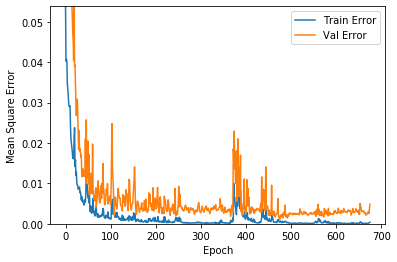

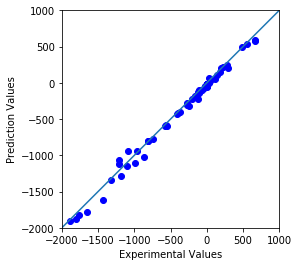

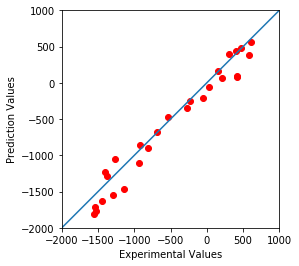

Epoch :  675
TRAINING :   R2 : 0.993099418852762 RSME : 53.29183678893393  MAE : 40.49727093625353
TEST :   R2 : 0.9621841222677484 RSME : 174.2575032282491  MAE : 141.75345749860352


In [3]:
# get dataset from csv file

path='Final Model\\'

if os.path.exists(path)==False:
    os.mkdir(path)

def build_model(n1,n2):
    inputL = Input(shape=(7,))

        
    z=Dense(n1,activation="relu")(inputL)
    z=Dense(n2,activation="relu")(z)
    z=Dense(1,activation="tanh")(z)
        
    x=Model(inputs=inputL, outputs=z)
       
    return x
 
#NN parameter
EPOCHS=40000
#loss_function= 'mean_absolute_error' 
loss_function= 'mean_squared_error'
optimizer = tf.keras.optimizers.Adam(0.0075)
#optimizer = tf.keras.optimizers.RMSprop(lr[a])

#directory setting
num=1
dir_path=path+'Trial-'+str(num)+'\\'
while os.path.exists(dir_path):
    num=num+1
    dir_path=path+'Trial-'+str(num)+'\\'

os.mkdir(dir_path)
print('Trial-',num)
x_train=x


early_stop=keras.callbacks.EarlyStopping(monitor='val_loss',mode='min',patience=200)


model=build_model(28,28)

mc = keras.callbacks.ModelCheckpoint(dir_path+'best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
# compile model
model.compile(loss=loss_function,optimizer=optimizer, metrics=['mean_absolute_error','mean_squared_error'])

history= model.fit(x_train,y , epochs=EPOCHS+1, validation_data=(x_val,y_val),verbose = 0,callbacks=[mc,early_stop])

model.save(dir_path+'model.h5')

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

hist.to_csv(dir_path+'error.csv')

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error')
plt.plot(hist['epoch'], hist['mean_absolute_error'],
                       label='Train Error')
plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
                       label='Val Error')
plt.ylim([0,hist['mean_absolute_error'].iloc[0]])
plt.legend()
plt.show()

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error')
plt.plot(hist['epoch'], hist['mean_squared_error'],
                       label='Train Error')
plt.plot(hist['epoch'], hist['val_mean_squared_error'],
                       label='Val Error')
plt.ylim([0,hist['mean_squared_error'].iloc[0]])
plt.legend()
plt.show()

train_predictions= model.predict(x_train).flatten()
train_predictions=train_predictions*2500

dataset=raw_dataset.copy()
dataset['Predict']=train_predictions
dataset.to_csv(dir_path+'train.csv')

y_=y*2500

plt.figure()
plt.scatter(y_, train_predictions,color='b')
plt.xlabel('Experimental Values')
plt.ylabel('Prediction Values')
plt.axis('equal')
plt.axis('square')
plt.xlim([-2000,1000])
plt.ylim([-2000,1000])
_ = plt.plot([-2000, 2000], [-2000, 2000])
plt.show()

#plot_model(model, to_file=dir_path+'model_plot_1.png', show_shapes=True, show_layer_names=True)

r2_train=r2(y_,train_predictions)
rmse_train=rmse(y_,train_predictions)
mae_train=mae(y_,train_predictions)

test_predictions= model.predict(x_val).flatten()
test_predictions=test_predictions*2500

dataset2=raw_dataset2.copy()
dataset2['Predict']=test_predictions
dataset2.to_csv(dir_path+'test.csv')

y_val_=y_val*2500

plt.figure()
plt.scatter(y_val_, test_predictions,color='r')
plt.xlabel('Experimental Values')
plt.ylabel('Prediction Values')
plt.axis('equal')
plt.axis('square')
plt.xlim([-2000,1000])
plt.ylim([-2000,1000])
_ = plt.plot([-2000, 2000], [-2000, 2000])
plt.show()


xr2_train=r2(y_val_,test_predictions)
xrmse_train=rmse(y_val_,test_predictions)
xmae_train=mae(y_val_,test_predictions)



print('Epoch : ', str(hist['epoch'].tail(1).iloc[0])) 
print('TRAINING : ' ,' R2 :',str(r2_train),'RSME :',str(rmse_train),' MAE :',str(mae_train))
print('TEST : ' ,' R2 :',str(xr2_train),'RSME :',str(xrmse_train),' MAE :',str(xmae_train))
K.clear_session()

# Re-Test 

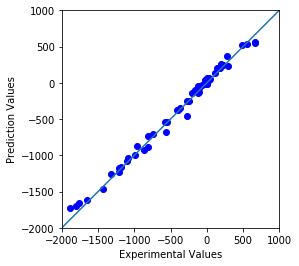

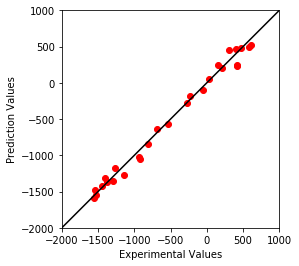

TRAINING :   R2 : 0.9925269598322085 RSME : 49.648830450565086  MAE : 37.76856503993389
TEST :   R2 : 0.9884526077148865 RSME : 84.23129354454971  MAE : 68.58633896335826


In [4]:
dir_path='Final Model\\Trial-8\\'
load_path=dir_path+'best_model.h5'
model = keras.models.load_model(load_path)

x_train=x
train_predictions= model.predict(x_train).flatten()
train_predictions=train_predictions*2500
dataset=raw_dataset.copy()
dataset['Predict']=train_predictions
dataset.to_csv(dir_path+'train.csv')

y_=y*2500

plt.figure()
plt.scatter(y_, train_predictions,color='b')
plt.xlabel('Experimental Values')
plt.ylabel('Prediction Values')
plt.axis('equal')
plt.axis('square')
plt.xlim([-2000,1000])
plt.ylim([-2000,1000])
_ = plt.plot([-2000, 2000], [-2000, 2000])
plt.show()



r2_train=r2(y_,train_predictions)
rmse_train=rmse(y_,train_predictions)
mae_train=mae(y_,train_predictions)

test_predictions= model.predict(x_val).flatten()
test_predictions=test_predictions*2500
dataset2=raw_dataset2.copy()
dataset2['Predict']=test_predictions
dataset2.to_csv(dir_path+'test.csv')

y_val_=y_val*2500

plt.figure()
plt.scatter(y_val_, test_predictions,color='r')
plt.xlabel('Experimental Values')
plt.ylabel('Prediction Values')
plt.axis('equal')
plt.axis('square')
plt.xlim([-2000,1000])
plt.ylim([-2000,1000])
_ = plt.plot([-2000, 2000], [-2000, 2000],color='k')
plt.show()



xr2_train=r2(y_val_,test_predictions)
xrmse_train=rmse(y_val_,test_predictions)
xmae_train=mae(y_val_,test_predictions)



# print('Epoch : ', str(hist['epoch'].tail(1).iloc[0])) 
print('TRAINING : ' ,' R2 :',str(r2_train),'RSME :',str(rmse_train),' MAE :',str(mae_train))
print('TEST : ' ,' R2 :',str(xr2_train),'RSME :',str(xrmse_train),' MAE :',str(xmae_train))
K.clear_session()

# Predict in Batch

For Static force vs depth

In [ ]:
#insert parameter 
def set_mat(material):
    
    if material =='718':
        uts=250
        ys=17.62
        hard=250
        cr=18.84
    if material =='718p':
        uts=684
        ys=9.5
        hard=250
        cr=18.84
    elif material=='600':
        uts=185
        ys=9.42
        hard=160
        cr=16.35
    elif material=='690':
        uts=211
        ys=11.6
        hard=211
        cr=29.9
    return uts,ys,hard,cr

load_path='Final Model\\Trial-6\model.h5'
model = keras.models.load_model(load_path)

In [ ]:
uts,ys,hard,cr=set_mat('600')

In [ ]:
st_force=10
amp=30
num_strike=8571
max_depth=1000

data=np.zeros(((max_depth+1),7))
 
data[:,0]=uts
data[:,1]=ys
data[:,2]=cr
data[:,6]=amp
data[:,4]=num_strike
data[:,3]=np.arange(max_depth+1)

#loaded model

model = keras.models.load_model(load_path)

for z in range(10):
    z=z+1
    
    data[:,5]=st_force*z
    #normalization
    normed=norm(data)
    

    temp=pd.DataFrame(data,columns=column_names_r)
    test_predictions= model.predict(normed).flatten()
    temp['Prediction']=test_predictions
    
    if z==1:
        res=temp.copy()
    else:
        res=res.append(temp,ignore_index=True, sort=False)




static=res[['Depth','Static Force','Prediction']]


X=res['Depth'].values
Y=res['Static Force'].values
Z=res['Prediction'].values
X=X.reshape((10, 1001))
Y=Y.reshape((10, 1001))
Z=Z.reshape((10, 1001))
plt.figure(figsize=(7,5))
plt.xlabel('Depth')
plt.ylabel('Static Force')
plt.contourf( X[0,:],Y[:,0],Z, cmap='RdBu')
clb = plt.colorbar()
clb.ax.set_title('Residual Stress')
plt.show()


For amplitude vs depth

In [ ]:
st_force=30
amp=10
num_strike=8571
max_depth=1000

data=np.zeros(((max_depth+1),7))

data[:,0]=uts
data[:,1]=ys
data[:,2]=cr
data[:,5]=st_force
data[:,4]=num_strike
data[:,3]=np.arange(max_depth+1)

#loaded model

model = keras.models.load_model(load_path)

for z in range(10):
    z=z+1
    
    data[:,6]=amp*z
    #normalization
    normed=norm(data)
    

    temp=pd.DataFrame(data,columns=column_names_r)
    test_predictions= model.predict(normed).flatten()
    temp['Prediction']=test_predictions
    
    if z==1:
        res=temp.copy()
    else:
        res=res.append(temp,ignore_index=True, sort=False)




amplitude=res[['Depth','Amplitude','Prediction']]


X=res['Depth'].values
Y=res['Amplitude'].values
Z=res['Prediction'].values
X=X.reshape((10, 1001))
Y=Y.reshape((10, 1001))
Z=Z.reshape((10, 1001))
plt.figure(figsize=(7,5))
plt.xlabel('Depth')
plt.ylabel('Amplitude')
plt.contourf( X[0,:],Y[:,0],Z, cmap='RdBu')
clb = plt.colorbar()
clb.ax.set_title('Residual Stress ')
plt.show()

For Number of strikes vs depth

In [ ]:
st_force=30
amp=30
num_strike=1000
max_depth=1000

data=np.zeros(((max_depth+1),7))

data[:,0]=uts
data[:,1]=ys
data[:,2]=cr
data[:,5]=st_force
data[:,6]=amp
data[:,3]=np.arange(max_depth+1)

#loaded model

model = keras.models.load_model(load_path)

for z in range(10):
    z=z+1
    
    data[:,4]=num_strike*z
    #normalization
    normed=norm(data)
    

    temp=pd.DataFrame(data,columns=column_names_r)
    test_predictions= model.predict(normed).flatten()
    temp['Prediction']=test_predictions
    
    if z==1:
        res=temp.copy()
    else:
        res=res.append(temp,ignore_index=True, sort=False)



Nums=res[['Depth','Strikes/mm2','Prediction']]


X=res['Depth'].values
Y=res['Strikes/mm2'].values
Z=res['Prediction'].values
X=X.reshape((10, 1001))
Y=Y.reshape((10, 1001))
Z=Z.reshape((10, 1001))
plt.figure(figsize=(7,5))
plt.xlabel('Depth')
plt.ylabel('Number of Strikes/mm2')
plt.contourf( X[0,:],Y[:,0],Z, cmap='RdBu')
clb = plt.colorbar()
clb.ax.set_title('Residual Stress')
plt.show()


In [ ]:
st_force=30
amp=30
num_strike=3000
max_depth=1000

data=np.zeros(((max_depth+1),7))

data[:,0]=uts
data[:,1]=ys
data[:,2]=cr
data[:,5]=st_force
data[:,6]=amp
data[:,3]=np.arange(max_depth+1)

#loaded model

model = keras.models.load_model(load_path)

for z in range(10):
    z=z+1
    
    data[:,4]=num_strike*z
    #normalization
    normed=norm(data)
    

    temp=pd.DataFrame(data,columns=column_names_r)
    test_predictions= model.predict(normed).flatten()
    temp['Prediction']=test_predictions
    
    if z==1:
        res=temp.copy()
    else:
        res=res.append(temp,ignore_index=True, sort=False)



Nums=res[['Depth','Strikes/mm2','Prediction']]


X=res['Depth'].values
Y=res['Strikes/mm2'].values
Z=res['Prediction'].values
X=X.reshape((10, 1001))
Y=Y.reshape((10, 1001))
Z=Z.reshape((10, 1001))
plt.figure(figsize=(7,5))
plt.xlabel('Depth')
plt.ylabel('Number of Strikes/mm2')
plt.contourf( X[0,:],Y[:,0],Z, cmap='RdBu')
clb = plt.colorbar()
clb.ax.set_title('Residual Stress')
plt.show()


for static load vs amplitude 

In [ ]:
st_force=100
amp=10
num_strike=20000
max_depth=0

data=np.zeros(((10),7))
data[:,0]=uts
data[:,1]=ys
data[:,2]=cr
data[:,5]=np.arange(10,st_force+1,step=10)
data[:,4]=num_strike
data[:,3]=0
#loaded model


model = keras.models.load_model(load_path)

for z in range(10):
    z=z+1
    
    data[:,6]=amp*z
    #normalization
    normed=norm(data)
    

    temp=pd.DataFrame(data,columns=column_names_r)
    test_predictions= model.predict(normed).flatten()
    temp['Prediction']=test_predictions
    if z==1:
        res=temp.copy()
    else:
        res=res.append(temp,ignore_index=True, sort=False)


    
    
SvA=res[['Static Force','Amplitude','Prediction']]

X=res['Static Force'].values
Y=res['Amplitude'].values
Z=res['Prediction'].values
X=X.reshape((10, 10))
Y=Y.reshape((10, 10))
Z=Z.reshape((10, 10))
plt.figure(figsize=(7,5))
plt.xlabel('Static Force')
plt.ylabel('Amplitude')
plt.contourf( X[0,:],Y[:,0],Z, cmap='RdBu')
clb = plt.colorbar()
clb.ax.set_title('Residual Stress')
plt.show()


In [ ]:
K.clear_session()

In [ ]:
final_data=pd.concat([static,amplitude],axis=1)
final_data=pd.concat([final_data,Nums],axis=1)
final_data=pd.concat([final_data,SvA],axis=1)


num=1;
file='result-'+str(num)+'.csv'
while os.path.exists(file):
    num=num+1
    file='result-'+str(num)+'.csv'
final_data.to_csv(file)

# Single Predict

In [ ]:
def sim(mat,x,y,z):   
    
        #insert parameter 
    uts,ys,hard,cr=set_mat(mat)

    st_force=x
    amp=y
    num_strike=z
    max_depth=1000


    data=np.zeros(((max_depth+1),7))

    data[:,0]=uts
    data[:,1]=ys
    data[:,2]=cr
    data[:,6]=amp
    data[:,4]=num_strike
    data[:,3]=np.arange(max_depth+1)
    data[:,5]=st_force 
        
    

    normed=norm(data)  

    temp=pd.DataFrame(data,columns=column_names_r)
    test_predictions= model.predict(normed).flatten()
    res=pd.DataFrame(data,columns=column_names_r)
    res['Predict']=test_predictions


    fig, ax = plt.subplots()
    ax.set_xlabel('Depth')
    ax.set_ylabel('Residual Stress')
    ax.plot(res['Depth'], res['Predict'],label='Predict')

    ax.set_xlim([0,max_depth+1])
    ax.axhline(y=0, color='k')
    # set the y-spine
    ax.grid(linestyle=':')
    ax.set_ylim([-2000,750])
    ax.legend()



    print('Max Compressive Stress :', np.min(res['Predict']))
    print('Max Tensile Stress :', np.max(res['Predict']))

    for k in range(max_depth+1):
        if res['Predict'][k]<0:
            temp = res['Predict'][k]
            temp1=k
        elif res['Predict'][k]>0:
            break


    print('Depth : ',res['Depth'][temp1],res['Predict'][temp1])



    num=1;
    file='result-'+str(num)+'.csv'
    while os.path.exists(file):
        num=num+1
        file='result-'+str(num)+'.csv'


    #res.to_csv(file)

            
def sim_c(mat,x,y,z,rs_d,rs_v):   
    
        #insert parameter 
       
    
    uts,ys,hard,cr=set_mat(mat)

    st_force=x
    amp=y
    num_strike=z
    max_depth=1000


    data=np.zeros(((max_depth+1),7))

    data[:,0]=uts
    data[:,1]=ys
    data[:,2]=cr
    data[:,6]=amp
    data[:,4]=num_strike
    data[:,3]=np.arange(max_depth+1)
    data[:,5]=st_force 
        


    normed=norm(data)

    test_predictions= model.predict(normed).flatten()

    res=pd.DataFrame(data,columns=column_names_r)
    res['Predict']=test_predictions


    fig, ax = plt.subplots()
    ax.set_xlabel('Depth')
    ax.set_ylabel('Residual Stress')
    ax.plot(res['Depth'], res['Predict'],label='Predict')
    ax.scatter(rs_d,rs_v,label='Ex')  
    ax.set_xlim([0,max_depth+1])
    ax.set_ylim([-2000,750])
    ax.axhline(y=0, color='k')
    # set the y-spine
    ax.grid(linestyle=':')
    #plt.ylim([-1000,1000])
    ax.legend()





    print('Max Compressive Stress :', np.min(res['Predict']))
    print('Max Tensile Stress :', np.max(res['Predict']))

    for k in range(max_depth+1):
        if res['Predict'][k]<0:
            temp = res['Predict'][k]
            temp1=k
        elif res['Predict'][k]>0:
            break


    print('Depth : ',res['Depth'][temp1],res['Predict'][temp1])


    num=1;
    file='result-'+str(num)+'.csv'
    while os.path.exists(file):
        num=num+1
        file='result-'+str(num)+'.csv'


    #res.to_csv(file)

In [ ]:
sim('600',100,30,8500)

In [ ]:
sim('600',50,30,8500)

In [ ]:
sim('600',120,30,8500)

In [ ]:
sim('600',120,50,20000)

In [ ]:
sim('690',120,50,20000)

In [ ]:
sim('718',50,30,5000)

In [ ]:
sim('690',120,30,8500)

In [ ]:
sim('718',50,50,8500)

In [ ]:
sim('718',80,30,8500)

In [ ]:
sim('718',50,50,50000)

In [ ]:
sim('718p',80,60,10000)

In [ ]:
sim('718',80,10,20000)

In [ ]:
sim('690',50,50,8571)

In [ ]:
sim('690',50,50,40000)

In [ ]:
rs_v=[-1562.31245,-1532.840686,-1540.24401,-1451.828716,-1300.760066,
      -1138.649029,-928.6667891,-807.1270609,-685.5846109,-232.5229142,
      161.5598696,585.130749,607.0086622,473.8468029,407.2767605,311.2022918]
rs_d=[0,10,20,30,40,50,80,100,130,200,300,350,450,600,675,750]
sim_c('718',70,30,5714,rs_d,rs_v)

In [ ]:
rs_690=[-965,-741.8372491,-554.0228053,-412.0354238,-247.1411837,-125.5339892,-121.0811753,-19.85083147,119.5798519,134.2260956,176.8859217]
depth_690=[0,25,50,75,100,125,150,175,200,225,250]
sim_c('690',50,50,8571,depth_690,rs_690)